In [516]:
def printSecond(n):
    minute=60
    hour=60*60
    flag=0
    s=round(n%60,2)
    s='{}s'.format(s)
    n=n//60
    minute=n%60
    if minute==0:
        m=''
    else:
        m='{}min '.format(minute)
    n=n//60
    hour=n
    if hour==0:
        h=''
    else:
        h='{}h '.format(hour)

    return(h+m+s)

In [517]:
import cv2
import numpy as np
from PIL import Image
import os
import random
import copy
import math
import time
import matplotlib.pyplot as plt
import sys
import requests
import json
sys.setrecursionlimit(10000000)

In [518]:
def get_coordinate(city_name,print_it=False):
    """
    city_name为中午 字符串形式
    """
    url0='https://restapi.amap.com/v3/geocode/geo?'
    my_key='88551836b6d0f8bd9f5a97dbb57d5741'
    key='key='+my_key
    address='&address='+city_name
    ##
    url=url0+key+address
    html=requests.get(url)
    data=json.loads(html.text)
    ##
    if print_it==True:
        print('{}的经纬度为：{}'.format(city_name,data['geocodes'][0]['location']))
    return(data['geocodes'][0]['location'])

In [519]:
def _base_map_url():
    url0='https://restapi.amap.com/v3/staticmap?'
    my_key='88551836b6d0f8bd9f5a97dbb57d5741'
    key='key='+my_key
    ####################################################
    #地图大小
    zoom='&zoom=4'#缩放级别[1,17] 1比例尺最大
    size='&size=1024*1024'#1024*1024最大
    my_location=get_coordinate('重庆')
    scale='&scale=1'
    location='&location='+my_location
    
    the_url=url0+key+zoom+size+location+scale
    return the_url

def _is_right_color(frame,rgb=np.array([0,255,0])):
    """
    frame[241 248 251]
    rgb=[241 248 251],<class 'numpy.ndarray'>
    """
    if (frame==rgb).all():
        return True
    else:
        return False
    
def drawMap(citie_name_list,pic_name):
    
    map_url=_base_map_url()
    html=requests.get(map_url)
    fp=open(pic_name,'wb')
    fp.write(html.content)
    fp.close()
    
    my_pathstyle='5,0x00FF00,1,,0'
    
    for i in range(len(citie_name_list)):
        city1=citie_name_list[i]
        city2=citie_name_list[(i+1)%len(citie_name_list)]
        coordinate1=get_coordinate(city1)
        coordinate2=get_coordinate(city2)
        coordinate=':{};{}'.format(coordinate1,coordinate2)
        one_path=my_pathstyle+coordinate
        paths='&paths='+one_path
        url=map_url+paths
        html=requests.get(url)
        fp=open('one_path.png','wb')
        fp.write(html.content)
        fp.close()
        
        #整合标记
        img=cv2.imread('one_path.png')
        result=[]
        for x in range(len(img)):
            for y in range(len(img[x])):
                #print(type(img[x][y]))
                if _is_right_color(img[x][y]):
                    result.append((x,y))
        img_main=cv2.imread(pic_name)
        for (x,y) in result:
            img_main[x][y]=np.array([0,255,255])
        cv2.imwrite(pic_name,img_main)
        
        print('\r正在画图  已完成：{}%'.format(round(100*(i+1)/len(citie_name_list))),end='')
    
    display(Image.open(pic_name))
    
'''
pic_name='test.png'
drawMap(['重庆','上海','北京','南京','重庆'],pic_name)
display(Image.open(pic_name))
'''

"\npic_name='test.png'\ndrawMap(['重庆','上海','北京','南京','重庆'],pic_name)\ndisplay(Image.open(pic_name))\n"

In [520]:
def getOneDistance(i,j):
    """
    获得城市i到城市j的距离
    """
    global cities
    city_name=cities[i]
    fp=open('city_distance/{}.txt'.format(city_name))
    count=0
    for line in fp.readlines():
        if count==j:
            return int(line[:-1])
        count=count+1

In [521]:
def init(ants_num):
    global cities
    global distances
    global Pheromone
    global ants
    
    fp=open('cities.txt','r')
    cities=[]
    for line in fp.readlines():
        cities.append(line[:-1])
    fp.close()
    #cities存的是所有城市的名字
    n=len(cities)
    #距离二维矩阵
    distances=[]
    for i in range(n):
        distances.append([])
        for j in range(n):
            d=getOneDistance(i,j)
            distances[i].append(d)    
    
    #信息素二维矩阵初始化
    global init_p
    Pheromone=[[init_p for j in range(n)] for i in range(n)]
    for x in range(n):
        P[x][x]=0
    
    #初始化蚂蚁 ants_num个
    ants=[]
    for _ in range(ants_num):
        ants.append(ant(random.randint(0,n-1)))
    

In [522]:
def nearestCities(i):
    """
    距离城市i的城市按距离由小到大排序
    """
    global distances
    class city():
        def __init__(self,index,distance):
            self.index=index
            self.distance=distance
    def quickSort(sort_list,start_i,end_j):
        if start_i>=end_j:
            return True
        key=sort_list[start_i].distance
        key_obj=sort_list[start_i]
        i=start_i
        j=end_j
        while(i<j):
            while(i<j and sort_list[j].distance>=key):
                j=j-1
            if(i<j):
                sort_list[i]=sort_list[j]
                i=i+1
            #
            while(i<j and sort_list[i].distance<key):
                i=i+1
            if(i<j):
                sort_list[j]=sort_list[i]
                j=j-1
        #i==j
        sort_list[i]=key_obj
        quickSort(sort_list,start_i,i-1)
        quickSort(sort_list,i+1,end_j)   
    
    sort_list=[]
    for j in range(len(distances[i])):
        sort_list.append(city(j,distances[i][j]))
    quickSort(sort_list,0,len(sort_list)-1)
    #for k in range(len(sort_list)):
    #    print(sort_list[k].distance)
    result=[]
    for k in range(1,len(sort_list)):
        result.append(sort_list[k].index)
    return result

#a=nearestCities(0)
#print(a)

In [523]:
class ant():
    global cities
    def __init__(self,start_city_index):
        self.allow=set()
        self.position=start_city_index
        self.route=[]
        self.route.append(start_city_index)
        for i in range(len(cities)):
            self.allow.add(i)
        self.allow.remove(start_city_index)
        self.finished=False
        self.distance=0
    def goto(self,i):
        self.distance=self.distance+getOneDistance(self.position,i)
        self.position=i
        self.route.append(i)
        self.allow.remove(i)
    def restart(self,start_city_index):
        self.allow=set()
        self.position=start_city_index
        self.route=[]
        self.route.append(start_city_index)
        for i in range(len(cities)):
            self.allow.add(i)
        self.allow.remove(start_city_index)
        self.finished=False
        self.distance=0
    def finish(self):
        self.finished=True
        
        
    def gotoNextCity(self):
        """
        在城市i选择前进的下一个城市j
        """
        global Pheromone
        i=self.position
        if len(self.allow)==0:
            self.finish()
            return False

        def itaij(i,j):
            """
            求城市i到j的启发函数（距离导数）期望程度
            i!=j
            """
            global distances
            dij=distances[i][j]
            return 1/dij
        def oneItem(j):
            global alpha
            global beta
            return ((Pheromone[i][j])*alpha)*((itaij(i,j))*beta)

        Denominator=0
        for k in self.allow:
            Denominator=Denominator+oneItem(k)

        dice=random.random()
        P=0
        for j in self.allow:
            numerator=oneItem(j)
            p=numerator/Denominator
            P=P+p
            if dice<=P:
                self.goto(j)
                return j

        

In [524]:
def distanceToAll(i):
    """
    城市i距离其他所有城市的距离之和
    """
    global distances
    result=0
    for j in range(len(distances[i])):
        result=result+distances[i][j]
    return result

In [525]:

def minAnt():
    global ants
    min_distance=ants[0].distance
    for ant in ants:
        if ant.distance<=min_distance:
            min_distance=ant.distance
            result=copy.deepcopy(ant)
    return result

In [526]:
def gotoNextCity(ant):
    """
    在城市i选择前进的下一个城市j
    """
    global Pheromone
    i=ant.position
    if len(ant.allow)==0:
        ant.finish()
        return False
    
    def itaij(i,j):
        """
        求城市i到j的启发函数（距离导数）期望程度
        i!=j
        """
        global distances
        dij=distances[i][j]
        return 1/dij
    def oneItem(j):
        global alpha
        global beta
        return ((Pheromone[i][j])**alpha)*((itaij(i,j))**beta)

    Denominator=0
    for k in ant.allow:
        Denominator=Denominator+oneItem(k)
        
    dice=random.random()
    P=0
    for j in ant.allow:
        numerator=oneItem(j)
        p=numerator/Denominator
        P=P+p
        if dice<=P:
            ant.goto(j)
            return j
        

In [527]:
def upgradePheromone():
    """
    更新信息素 先衰减，再加上新来的
    """
    global Pheromone
    global ants
    global remaining_rate
    min_distance=minDistance()
    for x in range(len(Pheromone)):
        for y in range(len(Pheromone)):
            Pheromone[x][y]=Pheromone[x][y]*remaining_rate
    global Q
    for ant in ants:
        one_delta=Q/ant.distance
        if ant.distance==min_distance:
            one_delta=one_delta*(1+len(ants)/30)
        for i in range(len(ant.route)):
            city1=ant.route[i]
            j=(i+1)%len(ant.route)
            city2=ant.route[j]

            Pheromone[city1][city2]=Pheromone[city1][city2]+one_delta

In [528]:
def main(iteration_times):
    start_time=time.time()
    global ants
    global cities
    global global_min_ant
    global global_min_distance
    min_distance=[]
    
    global_min_distance=10000000000
    global_min_distance_list=[]
    for loop in range(iteration_times):
        for t in range(len(cities)+1):
            for ant in ants:
                ant.gotoNextCity()
        Min_distance=minDistance()     
        upgradePheromone()
        min_dis=minAnt().distance
        min_distance.append(min_dis)
        #min_distance为每一个轮回的最短路径
        if min_dis<global_min_distance:
            global_min_distance=min_dis
            global_min_ant=minAnt()
        global_min_distance_list.append(global_min_distance)    
        #global_min_distance_list为全局最短距离
        
        for ant in ants:
        #重新开始
            ant.restart(random.randint(0,len(cities)-1))
        
        duration=round(time.time()-start_time,2)
        remaining=round(duration/(loop+1)*iteration_times-duration,2)
        duration=printSecond(duration)
        remaining=printSecond(remaining)
        print('\r第{}/{}次寻路 已耗时：{} 预计剩余：{}     '.format(loop+1,iteration_times,duration,remaining),end='')
        
        
    x=[i for i in range(len(min_distance))]
    y=[j for j in min_distance]
    plt.plot(x,y)
    x2=[i for i in range(len(global_min_distance_list))]
    y2=[j for j in global_min_distance_list]
    plt.plot(x2,y2)
    plt.show()
    print(global_min_ant.route)


第500/500次寻路 已耗时：47.19s 预计剩余：0.0s       

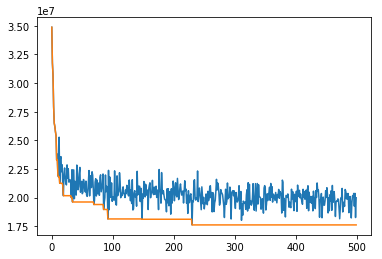

[25, 21, 3, 22, 23, 24, 31, 28, 33, 32, 29, 26, 1, 20, 17, 30, 18, 19, 27, 14, 15, 2, 6, 5, 4, 0, 7, 13, 16, 8, 12, 10, 11, 9]


In [543]:
if __name__=='__main__':
    
    init(50)
    global remaining_rate
    global alpha
    global beta
    global init_p
    global Q
    Q=1000
    init_p=0.0001
    remaining_rate=0.9
    alpha=0.2
    beta=0.3
    
    t=500
    main(t)



['拉萨', '成都', '重庆', '贵阳', '昆明', '南宁', '海口', '广州', '澳门', '香港', '福州', '杭州', '上海', '南京', '合肥', '台北', '武汉', '长沙', '南昌', '郑州', '济南', '天津', '沈阳', '长春', '哈尔滨', '北京', '呼和浩特', '银川', '太原', '石家庄', '西安', '兰州', '西宁', '乌鲁木齐']
正在画图  已完成：100%

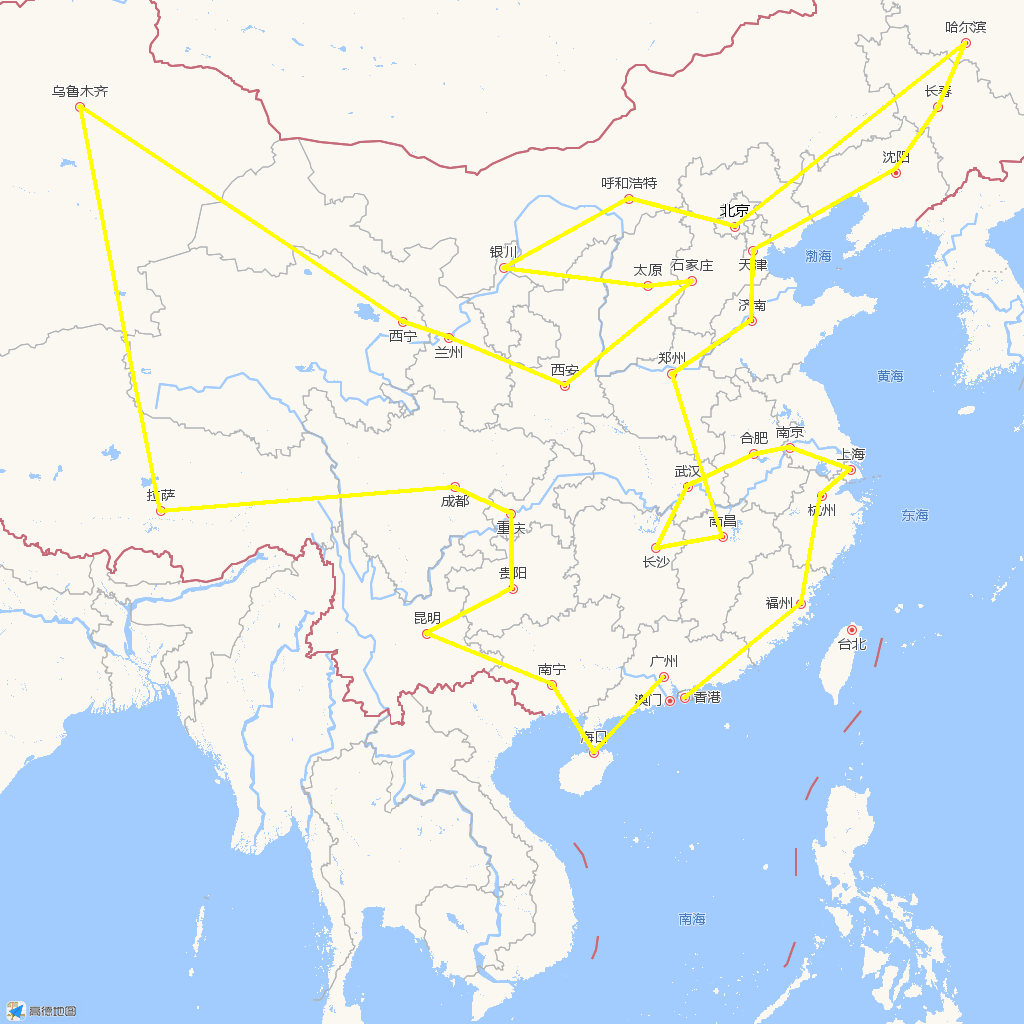

In [548]:
city_names=[]
global global_min_ant
for index in global_min_ant.route:
    city_names.append(cities[index])
print(city_names)
drawMap(city_names,'final.png')

第1000/1000次寻路 已耗时：1.0min 36.55s 预计剩余：0.0s      

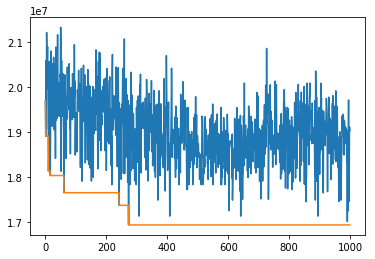

[4, 5, 6, 0, 2, 14, 12, 21, 3, 22, 23, 24, 31, 28, 33, 32, 29, 27, 19, 18, 30, 17, 20, 26, 1, 15, 8, 16, 7, 13, 10, 11, 9, 25]


In [549]:
main(1000)

['哈尔滨', '长春', '沈阳', '北京', '天津', '郑州', '西安', '成都', '重庆', '贵阳', '昆明', '南宁', '海口', '广州', '澳门', '香港', '福州', '南昌', '长沙', '武汉', '台北', '合肥', '南京', '杭州', '上海', '济南', '石家庄', '太原', '呼和浩特', '银川', '兰州', '西宁', '乌鲁木齐', '拉萨']
正在画图  已完成：100%

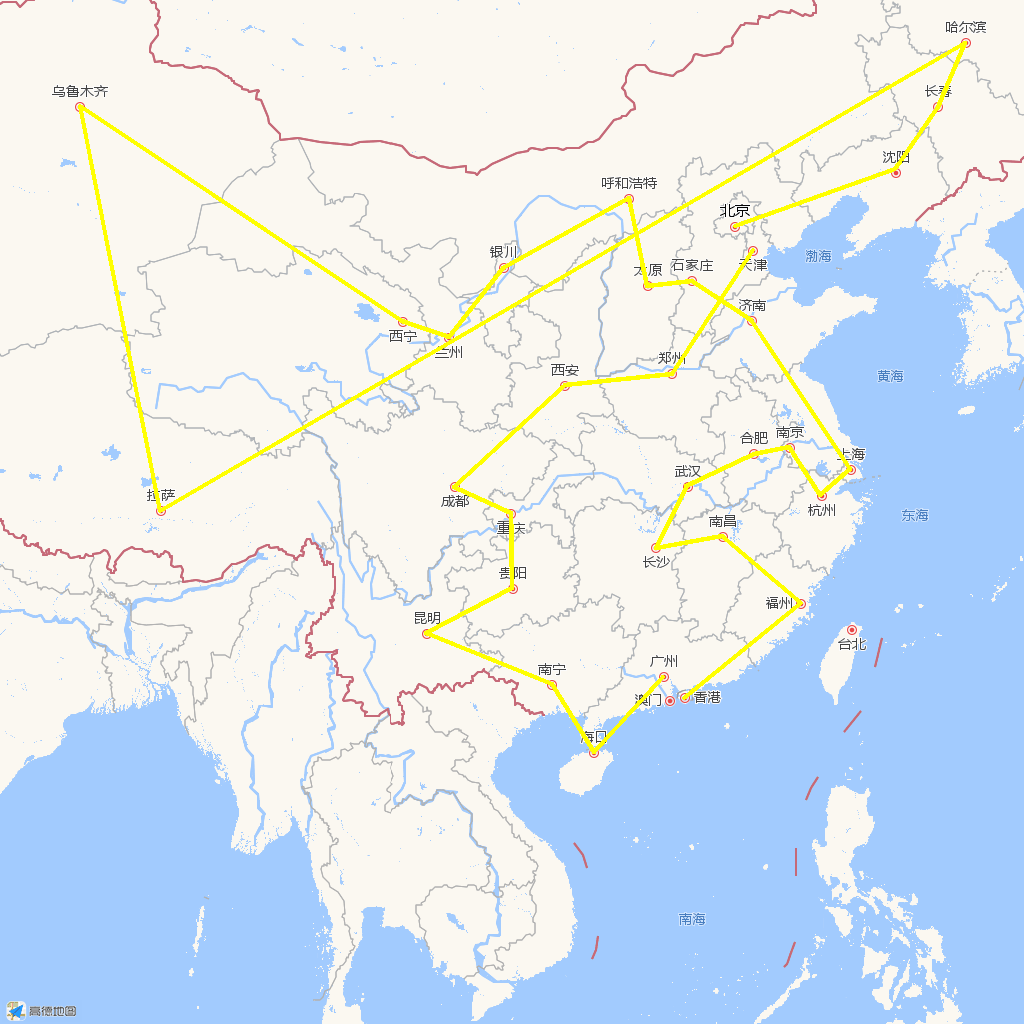

In [550]:
city_names=[]
global global_min_ant
for index in global_min_ant.route:
    city_names.append(cities[index])
print(city_names)
drawMap(city_names,'final.png')

第1000/1000次寻路 已耗时：1.0min 36.57s 预计剩余：0.0s      

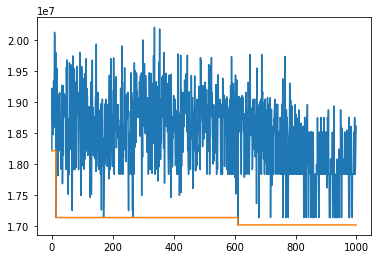

[9, 25, 21, 3, 22, 23, 24, 31, 28, 33, 32, 29, 27, 19, 18, 30, 17, 20, 26, 1, 15, 8, 16, 14, 12, 10, 11, 13, 7, 0, 2, 6, 5, 4]


In [551]:
main(1000)

['乌鲁木齐', '拉萨', '成都', '重庆', '贵阳', '昆明', '南宁', '海口', '广州', '澳门', '香港', '福州', '南昌', '长沙', '武汉', '台北', '合肥', '南京', '杭州', '上海', '济南', '石家庄', '太原', '郑州', '西安', '兰州', '西宁', '银川', '呼和浩特', '北京', '天津', '沈阳', '长春', '哈尔滨']
正在画图  已完成：100%

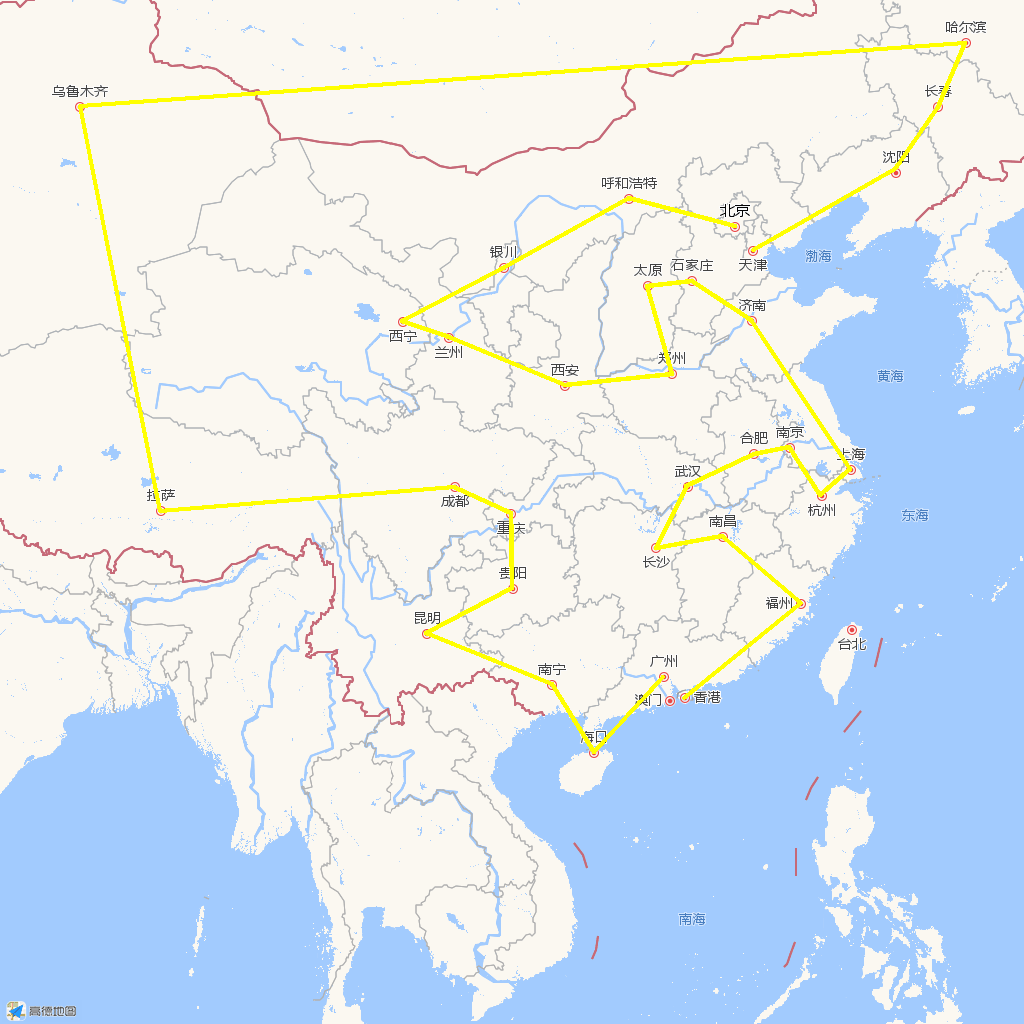

In [552]:
city_names=[]
global global_min_ant
for index in global_min_ant.route:
    city_names.append(cities[index])
print(city_names)
drawMap(city_names,'final.png')

第10000/10000次寻路 已耗时：15.0min 34.68s 预计剩余：0.0s      s      

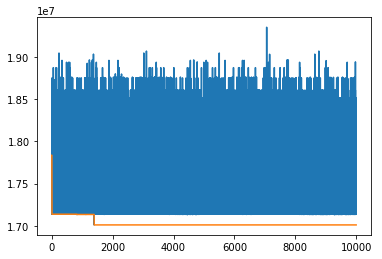

[25, 21, 3, 22, 23, 24, 31, 28, 33, 32, 29, 27, 19, 18, 30, 17, 20, 26, 1, 15, 2, 6, 5, 4, 7, 0, 8, 16, 14, 12, 13, 10, 11, 9]


In [553]:
main(10000)

['拉萨', '成都', '重庆', '贵阳', '昆明', '南宁', '海口', '广州', '澳门', '香港', '福州', '南昌', '长沙', '武汉', '台北', '合肥', '南京', '杭州', '上海', '济南', '天津', '沈阳', '长春', '哈尔滨', '呼和浩特', '北京', '石家庄', '太原', '郑州', '西安', '银川', '兰州', '西宁', '乌鲁木齐']
正在画图  已完成：100%

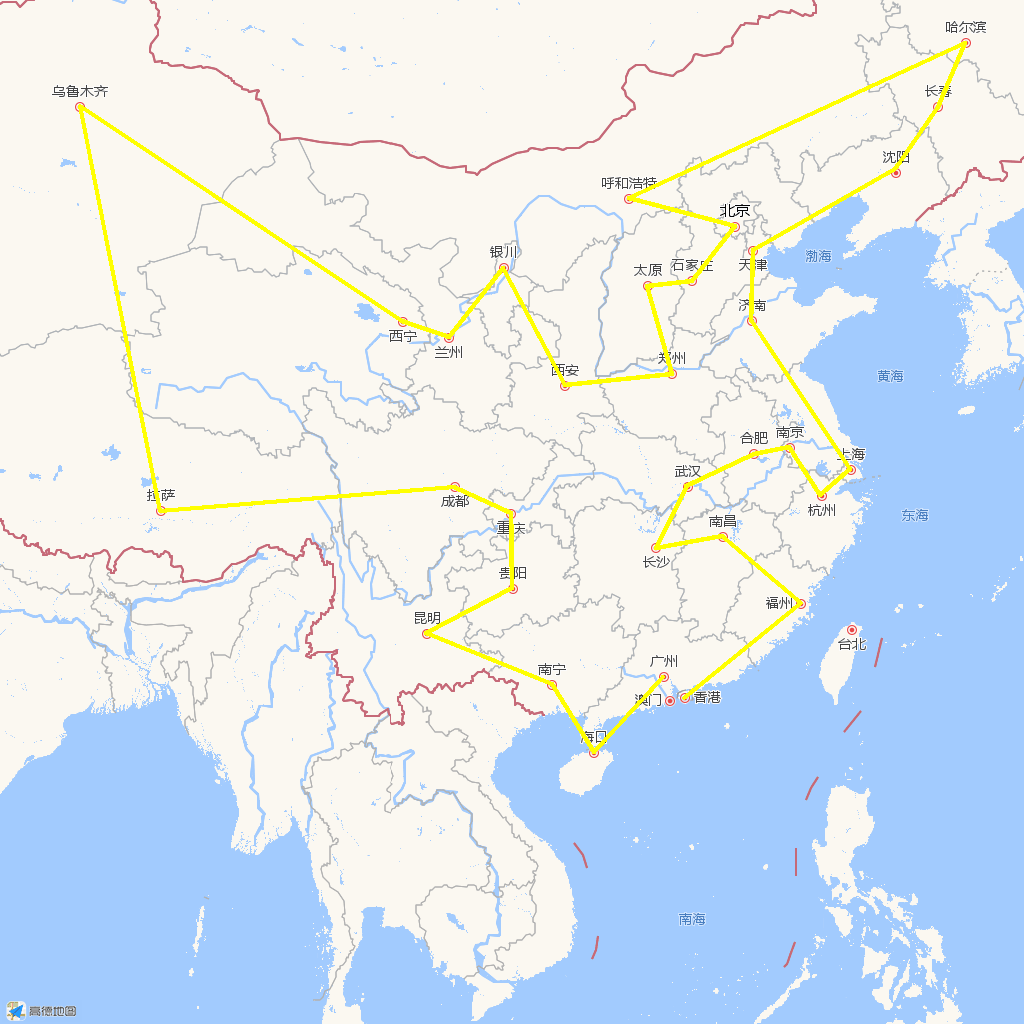

In [554]:
city_names=[]
global global_min_ant
for index in global_min_ant.route:
    city_names.append(cities[index])
print(city_names)
drawMap(city_names,'final.png')

第100/100次寻路 已耗时：9.34s 预计剩余：0.0s     

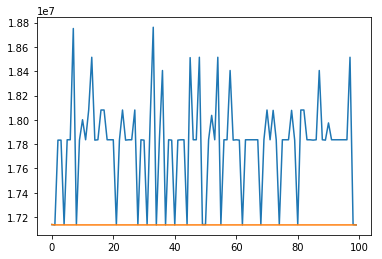

[25, 21, 3, 22, 23, 24, 31, 28, 33, 32, 29, 27, 19, 30, 18, 17, 20, 26, 1, 15, 8, 16, 7, 0, 2, 6, 5, 4, 14, 12, 13, 10, 11, 9]


In [556]:
main(100)

第100/100次寻路 已耗时：9.42s 预计剩余：0.0s     

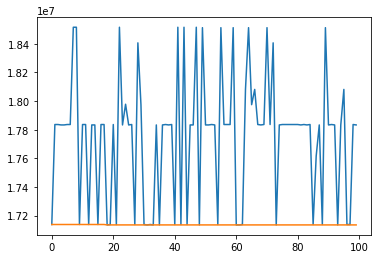

[25, 21, 3, 22, 23, 24, 31, 28, 33, 32, 29, 27, 19, 30, 18, 17, 20, 26, 1, 15, 8, 16, 7, 0, 2, 6, 5, 4, 14, 12, 13, 10, 11, 9]


In [558]:
main(100)

['拉萨', '成都', '重庆', '贵阳', '昆明', '南宁', '海口', '广州', '澳门', '香港', '福州', '南昌', '长沙', '台北', '武汉', '合肥', '南京', '杭州', '上海', '济南', '石家庄', '太原', '呼和浩特', '北京', '天津', '沈阳', '长春', '哈尔滨', '郑州', '西安', '银川', '兰州', '西宁', '乌鲁木齐']
正在画图  已完成：100%

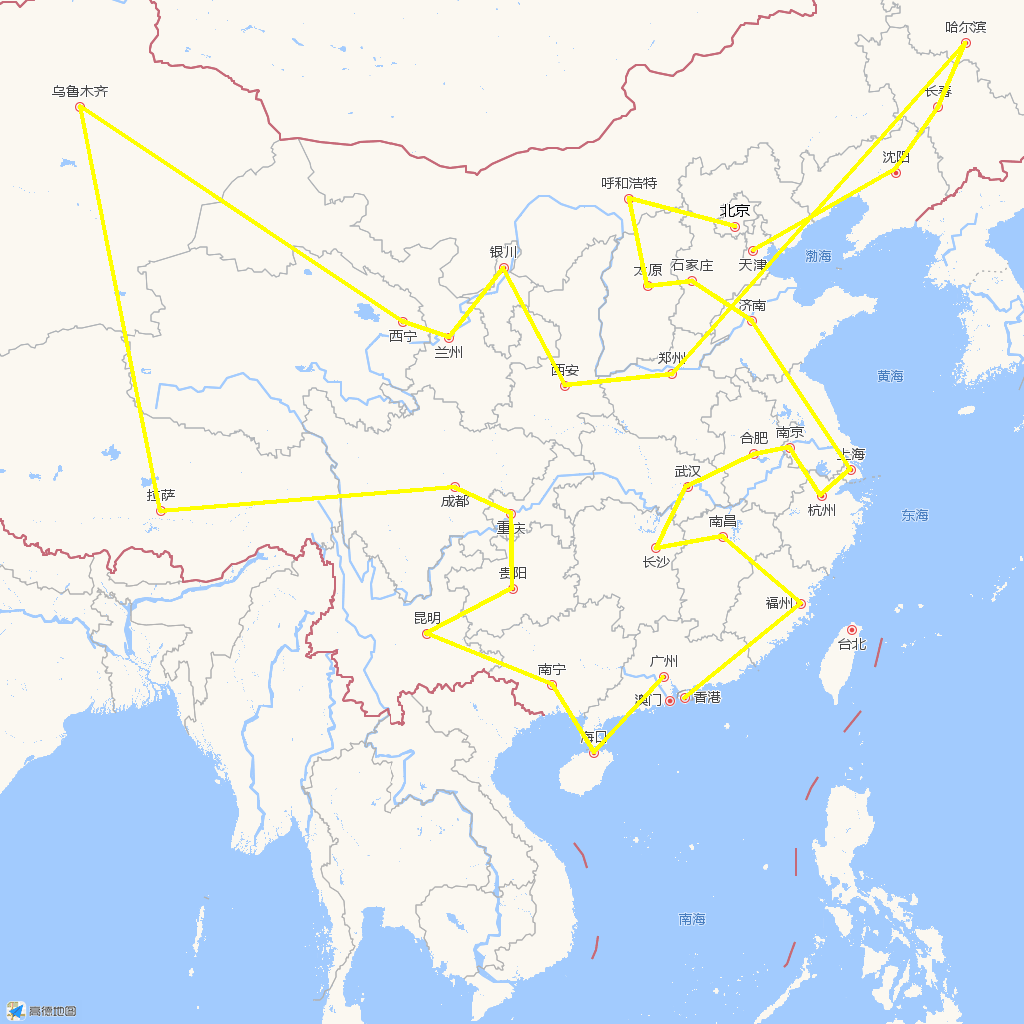

In [559]:
city_names=[]
global global_min_ant
for index in global_min_ant.route:
    city_names.append(cities[index])
print(city_names)
drawMap(city_names,'final2.png')